In [1]:
!pip install catboost
!pip install shap

  Using cached catboost-1.2.8-cp312-cp312-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached graphviz-0.21-py3-none-any.whl.metadata (12 kB)
  Using cached plotly-6.5.0-py3-none-any.whl.metadata (8.5 kB)
Using cached catboost-1.2.8-cp312-cp312-manylinux2014_x86_64.whl (99.2 MB)
Using cached graphviz-0.21-py3-none-any.whl (47 kB)
Using cached plotly-6.5.0-py3-none-any.whl (9.9 MB)
  Using cached shap-0.50.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (25 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
Using cached shap-0.50.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl (1.1 MB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier, Pool
from catboost import MetricVisualizer

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

pd.set_option("display.max_columns", None)


In [3]:
# Paths
base_dir = Path("data")
first_batch = base_dir / "faers_integration_batch_001.parquet"


In [4]:
class BatchDataLoader:
    def __init__(self, base_dir="data", start=1, end=15):
        self.base_dir = Path(base_dir)
        self.start, self.end = start, end
        self.mlb = None

    def iter_batches(self, chunksize=None):
        for i in range(self.start, self.end + 1):
            fp = self.base_dir / f"faers_integration_batch_{i:03d}.parquet"
            df = pd.read_parquet(fp, engine="pyarrow")
            yield df


In [5]:
df = pd.read_parquet(first_batch, engine="pyarrow")

df.shape


(1510448, 20)

In [6]:
df["max_severity"].value_counts(dropna=False)


max_severity
unknown             1177668
mild                 112323
severe                76490
moderate              72776
life-threatening      71191
Name: count, dtype: int64

In [7]:
df[["age", "sex", "max_severity"]].isna().sum()


age             387574
sex             212081
max_severity         0
dtype: int64

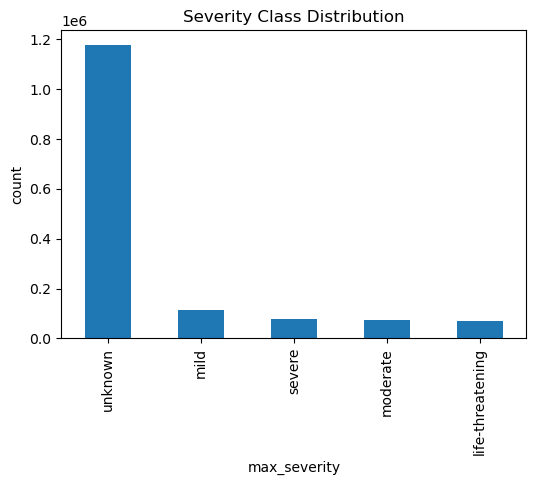

In [8]:
# Distribution plot
plt.figure(figsize=(6,4))
df["max_severity"].value_counts().plot(kind="bar")
plt.title("Severity Class Distribution")
plt.ylabel("count")
plt.savefig(
    "fig_severity_distribution_raw.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


In [9]:
# Rare class check
df["max_severity"].value_counts(normalize=True)


max_severity
unknown             0.779681
mild                0.074364
severe              0.050641
moderate            0.048182
life-threatening    0.047132
Name: proportion, dtype: float64

In [10]:
# Severity vs drug (top 20 drugs)
top_drugs = df["drug"].value_counts().head(20).index
tmp = df[df["drug"].isin(top_drugs)]
pd.crosstab(tmp["drug"], tmp["max_severity"])


max_severity,life-threatening,mild,moderate,severe,unknown
drug,,,,,
allopurinol,3294,4347,1875,2196,35043
aripiprazole,844,1984,1084,500,24592
atenolol,1374,4542,2106,1260,25164
carboplatin,4420,3808,2504,4472,73476
celecoxib,1365,3600,4245,4060,17775
cisplatin,1926,1035,1032,1605,24585
clozapine,4008,1290,1266,1014,63618
cyclophosphamide,1486,868,789,1689,22762
cytarabine,2436,856,924,1788,26948


In [11]:
# Severity vs gene (top 20 genes)
top_genes = df["gene"].value_counts().head(20).index
tmp = df[df["gene"].isin(top_genes)]
pd.crosstab(tmp["gene"], tmp["max_severity"])


max_severity,life-threatening,mild,moderate,severe,unknown
gene,,,,,
ACE,1319,687,412,953,19143
ADORA2A,1466,4248,3120,2953,28398
ARID5B,1466,4248,3120,2953,28398
BMP7,3309,8012,4862,3658,53026
CES1,997,1116,1229,1488,17945
CTLA4,1319,687,412,953,19143
CYP2C9,1224,2905,1748,958,30319
CYP2D6,1609,3197,1827,880,22639
CYP3A5,1027,2910,1345,785,19995


In [12]:
num_cols = [
    "expr_liver","expr_kidney","expr_colon","expr_intestine","expr_blood",
    "age","approval_year","regulatory_complexity"
]
df[num_cols].describe().loc[["mean", "std", "min", "max"]]


,expr_liver,expr_kidney,expr_colon,expr_intestine,expr_blood,age,approval_year,regulatory_complexity
mean,76.064810,24.134578,30.633454,46.826224,97.305550,52.659334,1998.924572,2.185683
std,234.358453,109.955561,151.531404,238.545398,804.544259,21.117104,17.721959,1.141451
min,0.000000,0.000000,0.000402,0.001319,0.000393,0.000000,1952.000000,1.000000
max,2189.972076,1231.923519,1751.140806,2830.483657,9209.872868,100.000000,2025.000000,6.500000


In [13]:
df[["age","sex"] + num_cols].isna().sum()


age                      387574
sex                      212081
expr_liver                    0
expr_kidney                   0
expr_colon                    0
expr_intestine                0
expr_blood                    0
age                      387574
approval_year                 0
regulatory_complexity         0
dtype: int64

In [14]:
len(df["drug"].unique()), len(df["gene"].unique())


(99, 150)

In [15]:
ldr = BatchDataLoader()

sev_counts = []

for batch_df in ldr.iter_batches():
    c = batch_df["max_severity"].value_counts()
    sev_counts.append(c)

sev_table = pd.DataFrame(sev_counts).fillna(0).astype(int)
sev_table


max_severity,unknown,mild,severe,moderate,life-threatening
count,1177668,112323,76490,72776,71191
count,1350103,139247,99824,92775,80590
count,1325017,127617,93353,85477,85169
count,1286775,137517,90912,88850,78248
count,1535796,168983,113813,112918,93030
count,1313777,143147,93981,94668,81755
count,1347166,139498,99444,95120,82113
count,1269984,136989,93535,92907,77131
count,1387112,149124,94266,95713,81277
count,1305489,141160,93017,91045,81676


In [16]:
# Aggregate severity distribution across all batches
sev_global = sev_table.sum(axis=0)
sev_global


max_severity
unknown             18431236
mild                 1894895
severe               1296832
moderate             1251048
life-threatening     1130945
dtype: int64

In [17]:
# Normalized distribution to check imbalance
sev_global / sev_global.sum()


max_severity
unknown             0.767810
mild                0.078938
severe              0.054024
moderate            0.052116
life-threatening    0.047113
dtype: float64

In [18]:
# Load one batch to fit encoders and inspect distributions
df0 = pd.read_parquet(first_batch, engine="pyarrow")

# Remove unknown severity
df0 = df0[df0["max_severity"] != "unknown"]

# Target mapping
sev_map = {
    "mild": 0,
    "moderate": 1,
    "severe": 2,
    "life-threatening": 3
}
df0["y"] = df0["max_severity"].map(sev_map)
df0["y"].value_counts()


y
0    112323
2     76490
1     72776
3     71191
Name: count, dtype: int64

In [19]:
feat_cols = [
    "age", "sex",
    "drug", "approval_year", "regulatory_complexity",
    "gene",
    "expr_liver","expr_kidney","expr_colon","expr_intestine","expr_blood"
]


In [20]:
drug_le = LabelEncoder()
gene_le = LabelEncoder()
sex_le = LabelEncoder()

# Fit on batch 001 filtered (encoders do not care about removed rows)
drug_le.fit(df0["drug"])
gene_le.fit(df0["gene"])
sex_le.fit(df0["sex"].fillna("MISSING"))


LabelEncoder()

In [21]:
def encode_batch(df):
    df = df[df["max_severity"] != "unknown"]
    
    # y
    y = df["max_severity"].map(sev_map).values
    
    # X
    X = df[feat_cols].copy()
    
    # age impute
    X["age"] = X["age"].fillna(df0["age"].mean())
    
    # sex impute and encode
    X["sex"] = X["sex"].fillna("MISSING")
    X["sex"] = sex_le.transform(X["sex"])
    
    # drug encode
    X["drug"] = drug_le.transform(X["drug"])
    
    # gene encode
    X["gene"] = gene_le.transform(X["gene"])
    
    return X.values, y


In [22]:
dfb = pd.read_parquet(first_batch, engine="pyarrow")
dfb = dfb[dfb["max_severity"] != "unknown"]

Xb, yb = encode_batch(dfb)

X_tr, X_te, y_tr, y_te = train_test_split(Xb, yb, test_size=0.2, stratify=yb, random_state=0)


In [23]:
lr = LogisticRegression(max_iter=200, n_jobs=-1)
lr.fit(X_tr, y_tr)

p_lr = lr.predict(X_te)

acc_lr = accuracy_score(y_te, p_lr)
f1_lr = f1_score(y_te, p_lr, average="macro")

acc_lr, f1_lr


/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.34019472324057937, 0.14506547916519022)

In [24]:

dt = DecisionTreeClassifier(max_depth=6)
dt.fit(X_tr, y_tr)

p_dt = dt.predict(X_te)

acc_dt = accuracy_score(y_te, p_dt)
f1_dt = f1_score(y_te, p_dt, average="macro")

acc_dt, f1_dt


(0.3917152473105355, 0.32368823890928033)

In [25]:

rf = RandomForestClassifier(n_estimators=50, max_depth=12, n_jobs=-1)
rf.fit(X_tr, y_tr)

p_rf = rf.predict(X_te)

acc_rf = accuracy_score(y_te, p_rf)
f1_rf = f1_score(y_te, p_rf, average="macro")

acc_rf, f1_rf


(0.4517549131558387, 0.4085803469459659)

In [26]:
class BatchLoaderModel2:
    def __init__(self, base_dir="data", start=1, end=15):
        self.base_dir = Path(base_dir)
        self.start = start
        self.end = end
        
        self.num_features = [
            "age","approval_year","regulatory_complexity",
            "expr_liver","expr_kidney","expr_colon","expr_intestine","expr_blood"
        ]
        
        self.cat_features = ["sex","drug","gene"]
        self.target = "max_severity"
        
        self.drop_cols = [
            "case_id","evidence_level","association_type",
            "event_count","has_severe_event","has_cardiac_event",
            "has_gi_event","event_categories"
        ]
        
        self.sev_map = {
            "mild":0,
            "moderate":1,
            "severe":2,
            "life-threatening":3
        }

    def iter_batches(self, frac=0.4):
        for i in range(self.start, self.end + 1):
            fp = self.base_dir / f"faers_integration_batch_{i:03d}.parquet"
            df = pd.read_parquet(fp, engine="pyarrow")
            
            # subsample
            df = df.sample(frac=frac, random_state=42)

            # drop irrelevant columns
            df = df.drop(columns=self.drop_cols, errors="ignore")

            # remove unknown severity
            df = df[df[self.target] != "unknown"]

            # target encode
            y = df[self.target].map(self.sev_map)

            # cat imputation
            df["sex"] = df["sex"].fillna("Unknown")

            # num imputation
            df["age"] = df["age"].fillna(df["age"].median())

            X = df[self.num_features + self.cat_features]

            yield X, y


In [27]:
loader = BatchLoaderModel2(start=1, end=15)

X_val, y_val = next(loader.iter_batches(frac=0.4))

val_idx = np.random.choice(len(X_val), size=50000, replace=False)
X_val_sub = X_val.iloc[val_idx]
y_val_sub = y_val.iloc[val_idx]

pool_val = Pool(
    X_val_sub,
    y_val_sub,
    cat_features=["sex","drug","gene"]
)

print("Validation size:", X_val_sub.shape)


Validation size: (50000, 11)


In [28]:
print("Loading training batches...")

X_parts = []
y_parts = []

for Xb, yb in loader.iter_batches(frac=0.4):
    X_parts.append(Xb)
    y_parts.append(yb)

X_train = pd.concat(X_parts, ignore_index=True)
y_train = pd.concat(y_parts, ignore_index=True)

print(f"Total training samples: {len(X_train):,}")


Loading training batches...
Total training samples: 2,229,948


In [29]:
pool_train = Pool(
    X_train,
    y_train,
    cat_features=["sex","drug","gene"]
)

model = CatBoostClassifier(
    iterations=7000,           # more trees for full data
    learning_rate=0.03,
    depth=10,
    l2_leaf_reg=3,
    border_count=254,
    bagging_temperature=1.0,
    random_strength=1,

    loss_function="MultiClass",
    eval_metric="MultiClass",
    metric_period=300,

    task_type="GPU",
    devices="0",
    boosting_type="Plain",

    random_seed=42,
    od_type="Iter",
    od_wait=200,      # allow more patience
    verbose=300
)


model.fit(
    pool_train,
    eval_set=pool_val,
    use_best_model=True
)

0:	learn: 1.3815282	test: 1.3818353	best: 1.3818353 (0)	total: 40.7ms	remaining: 4m 44s
300:	learn: 1.2286704	test: 1.2257991	best: 1.2257991 (300)	total: 10.1s	remaining: 3m 45s
600:	learn: 1.2010064	test: 1.1957775	best: 1.1957775 (600)	total: 20.3s	remaining: 3m 35s
900:	learn: 1.1841989	test: 1.1772955	best: 1.1772955 (900)	total: 30.7s	remaining: 3m 27s
1200:	learn: 1.1722033	test: 1.1639196	best: 1.1639196 (1200)	total: 40.9s	remaining: 3m 17s
1500:	learn: 1.1633487	test: 1.1542873	best: 1.1542873 (1500)	total: 51.4s	remaining: 3m 8s
1800:	learn: 1.1563917	test: 1.1467387	best: 1.1467387 (1800)	total: 1m 2s	remaining: 2m 59s
2100:	learn: 1.1508555	test: 1.1409493	best: 1.1409493 (2100)	total: 1m 13s	remaining: 2m 50s
2400:	learn: 1.1459333	test: 1.1359533	best: 1.1359533 (2400)	total: 1m 24s	remaining: 2m 41s
2700:	learn: 1.1418382	test: 1.1317042	best: 1.1317042 (2700)	total: 1m 35s	remaining: 2m 31s
3000:	learn: 1.1382509	test: 1.1281075	best: 1.1281075 (3000)	total: 1m 46s	rem

In [30]:
pred_val = model.predict(pool_val)
pred_val = pred_val.astype(int).flatten()  # CatBoost outputs class indices

macro_f1 = f1_score(y_val_sub, pred_val, average="macro")
print("Validation macro-F1:", macro_f1)

Validation macro-F1: 0.4946810359863223


                  feature  importance
0                     age   32.739650
9                    drug   22.432977
8                     sex   15.090262
1           approval_year   12.198937
2   regulatory_complexity   11.571029
10                   gene    2.363535
3              expr_liver    0.927633
7              expr_blood    0.813141
4             expr_kidney    0.715769
6          expr_intestine    0.582660
5              expr_colon    0.564407


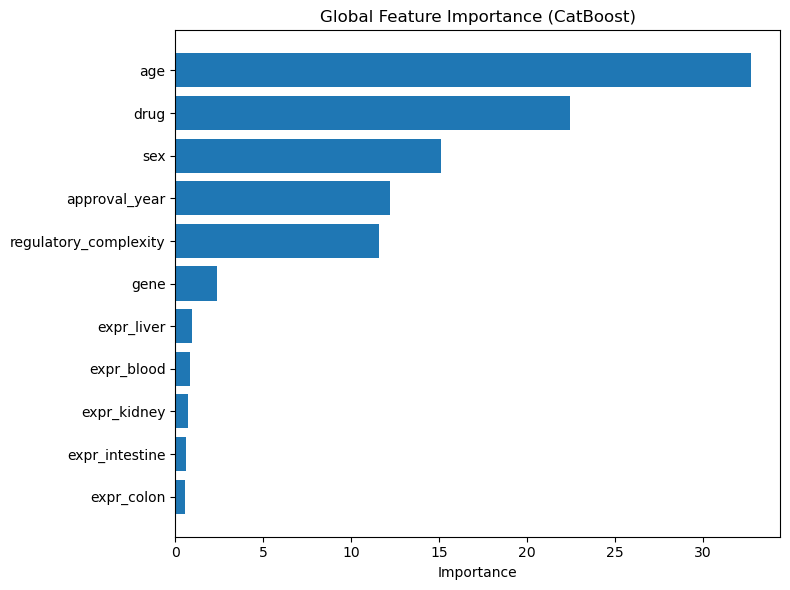

In [31]:
features = X_train.columns.tolist()
importances = model.get_feature_importance()

fi_df = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values("importance", ascending=False)

print(fi_df)

plt.figure(figsize=(8,6))
plt.barh(fi_df["feature"], fi_df["importance"])
plt.gca().invert_yaxis()
plt.title("Global Feature Importance (CatBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig(
    "fig_model2_feature_importance.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


In [32]:
class_importances = model.get_feature_importance(type="PredictionValuesChange")

cls_df = pd.DataFrame(
    class_importances,
    index=features,
    columns=["importance"]
)

print("Per-Class Feature Importances:")
print(cls_df)


Per-Class Feature Importances:
                       importance
age                     32.739650
approval_year           12.198937
regulatory_complexity   11.571029
expr_liver               0.927633
expr_kidney              0.715769
expr_colon               0.564407
expr_intestine           0.582660
expr_blood               0.813141
sex                     15.090262
drug                    22.432977
gene                     2.363535


Confusion Matrix:
[[12605  1181  1720  1456]
 [ 4880  3507  1590  1105]
 [ 3993   941  4825  1551]
 [ 3580   649  1355  5062]]


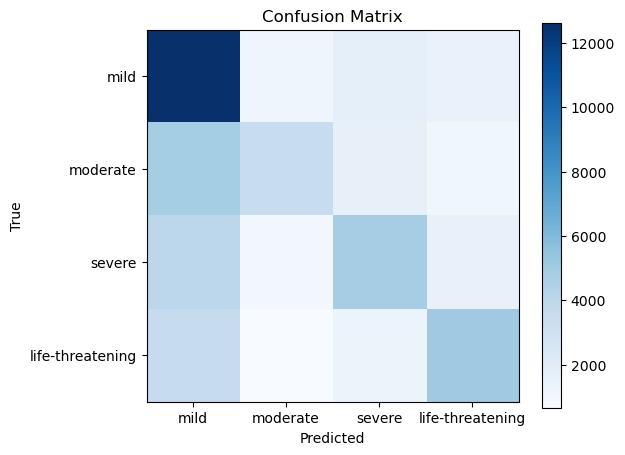

In [33]:
pred_val = model.predict(pool_val).astype(int).flatten()
cm = confusion_matrix(y_val_sub, pred_val)

print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0,1,2,3], ["mild","moderate","severe","life-threatening"])
plt.yticks([0,1,2,3], ["mild","moderate","severe","life-threatening"])
plt.show()


In [34]:
report = classification_report(
    y_val_sub,
    pred_val,
    target_names=["mild","moderate","severe","life-threatening"],
    output_dict=True
)

print("Per-Class Metrics:")
print(pd.DataFrame(report))


Per-Class Metrics:
                   mild      moderate        severe  life-threatening  \
precision      0.503033      0.558617      0.508430          0.551777   
recall         0.743132      0.316459      0.426614          0.475484   
f1-score       0.599952      0.404032      0.463942          0.510797   
support    16962.000000  11082.000000  11310.000000      10646.000000   

           accuracy     macro avg  weighted avg  
precision   0.51998      0.530464      0.526952  
recall      0.51998      0.490422      0.519980  
f1-score    0.51998      0.494681      0.506780  
support     0.51998  50000.000000  50000.000000  


In [35]:
probs = model.predict_proba(pool_val)

print("Probability shape:", probs.shape)
print("Sample probabilities:\n", probs[:5])  # safe print

# Per-class probability distribution
prob_df = pd.DataFrame(probs, columns=["p_mild","p_moderate","p_severe","p_life_threat"])
print(prob_df.describe())


Probability shape: (50000, 4)
Sample probabilities:
 [[0.48688409 0.23981481 0.09755322 0.17574789]
 [0.63602925 0.11488491 0.06927076 0.17981508]
 [0.16172073 0.52866916 0.03906201 0.27054811]
 [0.41442681 0.16692215 0.27571109 0.14293996]
 [0.34339965 0.15662789 0.25144806 0.2485244 ]]
             p_mild    p_moderate      p_severe  p_life_threat
count  50000.000000  50000.000000  50000.000000   50000.000000
mean       0.337139      0.221159      0.228991       0.212711
std        0.177017      0.142749      0.153745       0.167533
min        0.000281      0.000836      0.000817       0.001332
25%        0.193369      0.125657      0.115149       0.091580
50%        0.337556      0.200453      0.204031       0.163816
75%        0.451054      0.274982      0.308144       0.283365
max        0.967556      0.956976      0.985714       0.993836


In [36]:
# Standard accuracy (overall correct / total)
acc = accuracy_score(y_val_sub, pred_val)

# Per-class accuracy (recall for each class)
classes = np.unique(y_val_sub)
per_class_acc = []

for c in classes:
    mask = (y_val_sub == c)
    correct = (pred_val[mask] == c).sum()
    total = mask.sum()
    per_class_acc.append(correct / total)

macro_acc = np.mean(per_class_acc)

print("Overall Accuracy:", acc)
print("Macro Accuracy:", macro_acc)
print("\nPer-Class Accuracy:", per_class_acc)

# Macro F1 for reference
macro_f1 = f1_score(y_val_sub, pred_val, average="macro")
print("\nMacro F1:", macro_f1)

Overall Accuracy: 0.51998
Macro Accuracy: 0.49042204877567186

Per-Class Accuracy: [np.float64(0.7431317061667256), np.float64(0.31645912290200323), np.float64(0.4266136162687887), np.float64(0.47548374976517)]

Macro F1: 0.4946810359863223
